In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Loading and probing the Negative Controls data

In [2]:
df = pd.read_csv('negative_controls.csv')

In [3]:
df.shape[0]

1880086

In [4]:
df['strain_name'].unique()

array(['WT-Live-Control'], dtype=object)

In [5]:
if 'level_0' in df.columns:
    df.drop(columns='level_0', inplace=True)

In [6]:
df['inc_time_1_hrs'].unique(), df['inc_time_2_hrs'].unique()

(array([18, 16]), array([18, 15,  8, 16, 10, 12]))

In [7]:
df.set_index(['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event'], drop=True, inplace=True)

In [8]:
df['FSC_A'].max(), df['SSC_A'].max()

(1048575.0, 1048575.0)

In [9]:
main_body = df.query("FSC_A < 500_000 and SSC_A < 500_000").shape[0]
print(f"{main_body} events below 500,000; {(main_body * 100 / df.shape[0]):2.1f}%")

1338351 events below 500,000; 71.2%


In [10]:
df.head()

lab_id  \
strain_name     inc_temp_degrees inc_time_2_hrs media          od     plate_id replicate event                                
WT-Live-Control 37               18             standard_media 0.0003 0        42        0      r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                         1      r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                         2      r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                         3      r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                         4      r1ceuhqmu6c7w_r1cf6snbv99p8   

                                                                                               well  \
strain_name     inc_temp_degrees inc_time_2_hrs media          od     plate_id replicate event        
WT-Live-Control 37               18             standard_media 0.0003 0        42        0      A12   
                                                                                         1      A12   
                                                                                         2      A12   
                                                                                         3      A12   
                                                                                         4      A12   

                                                                                               inc_temp  \
strain_name     inc_temp_degrees inc_time_2_hrs media          od     plate_id replicate event            
WT-Live-Control 37               18             standard_media 0.0003 0        42        0      warm_37   
                                                                                         1      warm_37   
                                                                                         2      warm_37   
                                                                                         3      warm_37   
                                                                                         4      warm_37   

                                                                                               inc_time_1  \
strain_name     inc_temp_degrees inc_time_2_hrs media          od     plate_id replicate event              
WT-Live-Control 37               18             standard_media 0.0003 0        42        0        18:hour   
                                                                                         1        18:hour   
                                                                                         2        18:hour   
                                                                                         3        18:hour   
                                                                                         4        18:hour   

                                                                                               inc_time_2  \
strain_name     inc_temp_degrees inc_time_2_hrs media          od     plate_id replicate event              
WT-Live-Control 37               18             standard_media 0.0003 0        42        0        18:hour   
                                                                                         1        18:hour   
                                                                                         2        18:hour   
                                                                                         3        18:hour   
                                                                                         4        18:hour   

                                                                                                growth_media_1  \
strain_name     inc_temp_degrees inc_time_2_hrs media          od     plate_id replicate event                   

# Initial version of heatmap in paper

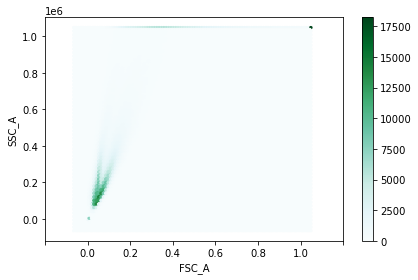

In [11]:
figure, ax = plt.subplots(1, 1)
df.plot.hexbin(x='FSC_A', y='SSC_A', ax=ax)
plt.gca().set_xlabel('FSC_A')
oticks, olabels = plt.xticks()
ticks, labels = plt.xticks(ticks=oticks, labels=['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', ''])
labels = plt.gca().set_xticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', ''])
plt.tight_layout()
plt.gcf().savefig('saturation_heatmap.pdf', format='pdf')


# Point cloud with more conventional plotting style

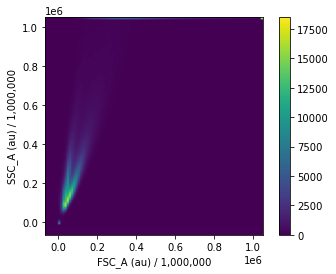

In [12]:
#b, a = np.meshgrid(np.linspace(0, 1_000_000, 1000), np.linspace(0, 1_000_000, 1000))
heatmap, xedges, yedges = np.histogram2d(df['FSC_A'], df['SSC_A'], bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
ax = plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
figure = plt.gcf()
figure.colorbar(ax)
plt.xlabel('FSC_A (au) / 1,000,000');
plt.ylabel('SSC_A (au) / 1,000,000');
# figure, axes = plt.subplots()
# c = np.stack((np.array(df['FSC_A']), np.array(df['SSC_A'])), axis=1)
# print(c.shape)
# plot = axes.pcolormesh(a, b, c, cmap='cool_r', vmin=0, vmax=1_000_000)
# figure.colorbar(plot)
# plt.show()

# Replot showing problem of superimposing on bitmap heatmaps

This figure shows the problem that when I make a heatmap as an image, I lose access to the data coordinates.

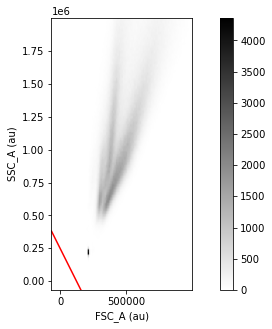

In [13]:
#b, a = np.meshgrid(np.linspace(0, 1_000_000, 1000), np.linspace(0, 1_000_000, 1000))
def gate_pic(data_frame):
    df = data_frame.query('FSC_A < 200_000 and SSC_A < 400_000')
    heatmap, xedges, yedges = np.histogram2d(df['FSC_A'], df['SSC_A'], bins=100)
    extent = [xedges[0], xedges[-1] * 5, yedges[0], yedges[-1] * 5]
    figure, ax = plt.subplots()
    figure.set_size_inches(10, 5)
    mappable = ax.imshow(heatmap.T, extent=extent, 
                         origin='lower', cmap='gray_r')
    figure.colorbar(mappable)
    ax.axline((25_000 * 5, 0), (0, 50_000 * 5), color='red')
    #ax.axline((25_000, 0), (0, 50_000))
    plt.xlabel('FSC_A (au)');
    plt.ylabel('SSC_A (au)');
# figure, axes = plt.subplots()
# c = np.stack((np.array(df['FSC_A']), np.array(df['SSC_A'])), axis=1)
# print(c.shape)
# plot = axes.pcolormesh(a, b, c, cmap='cool_r', vmin=0, vmax=1_000_000)
# figure.colorbar(plot)
# plt.show()

gate_pic(df)

# Some low outliers

In [14]:
df['FSC_A'].min()

-65536.0

In [15]:
df['SSC_A'].min()

-65536.0

In [16]:
df.query('SSC_A < 0 or FSC_A < 0')

lab_id  \
strain_name     inc_temp_degrees inc_time_2_hrs media                       od     plate_id replicate event                                
WT-Live-Control 37               18             standard_media              0.0003 0        42        211    r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                                      364    r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                                      1188   r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                                      1189   r1ceuhqmu6c7w_r1cf6snbv99p8   
                                                                                                      1231   r1ceuhqmu6c7w_r1cf6snbv99p8   
...                                                                                                                                  ...   
                                                high_osm_media_five_percent 0.0003 2        39        29783  r1ce3pm76spw4_r1ceas4zgsdt5   
                                                                                                      29807  r1ce3pm76spw4_r1ceas4zgsdt5   
                                                                                                      29910  r1ce3pm76spw4_r1ceas4zgsdt5   
                                                                                                      29919  r1ce3pm76spw4_r1ceas4zgsdt5   
                                                                                                      29974  r1ce3pm76spw4_r1ceas4zgsdt5   

                                                                                                            well  \
strain_name     inc_temp_degrees inc_time_2_hrs media                       od     plate_id replicate event        
WT-Live-Control 37               18             standard_media              0.0003 0        42        211    A12   
                                                                                                      364    A12   
                                                                                                      1188   A12   
                                                                                                      1189   A12   
                                                                                                      1231   A12   
...                                                                                                          ...   
                                                high_osm_media_five_percent 0.0003 2        39        29783  A12   
                                                                                                      29807  A12   
                                                                                                      29910  A12   
                                                                                                      29919  A12   
                                                                                                      29974  A12   

                                                                                                            inc_temp  \
strain_name     inc_temp_degrees inc_time_2_hrs media                       od     plate_id replicate event            
WT-Live-Control 37               18             standard_media              0.0003 0        42        211    warm_37   
                                                                                                      364    warm_37   
                                                                                                      1188   warm_37   
                                                                                                      1189   warm_37   
                                                                                

# Check to make sure that log-scaling will work

In [17]:
np.isnan(np.sum(np.log10(df['FSC_A']+1)))

/Users/rpg/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


False

In [18]:
np.isnan(np.sum(np.log10(df['SSC_A']+1)))

False

In [19]:
np.isfinite(np.sum(np.log10(df['FSC_A']+1)))

True

In [20]:
np.isfinite(np.sum(np.log10(df['SSC_A']+1)))

True

# Building heatmaps for point clouds using matplotlib and numpy

This approach is based on effectively taking a 2D numpy array and treating it as if it's an image. This has problems, because scaling the image loses the data coordinates, which is problematic for, e.g., superimposing a line on the diagram.

viridis


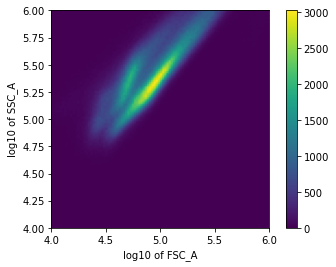

In [21]:
def get_heatmap(idf):
    df = idf.query('FSC_A > 0 and SSC_A > 0')
    #b, a = np.meshgrid(np.linspace(0, 1_000_000, 1000), np.linspace(0, 1_000_000, 1000))
    xs = np.log10(df['FSC_A']+1)
    ys = np.log10(df['SSC_A']+1)
    heatmap, xedges, yedges = np.histogram2d(xs, ys, bins=100, range=[[4, 6], [4, 6]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax = plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.xlabel('log10 of FSC_A')
    plt.ylabel('log10 of SSC_A')
    figure = plt.gcf()
    figure.colorbar(ax)
    cmap = mpl.cm.get_cmap()
    print(cmap)
    print(cmap.name)
    # figure, axes = plt.subplots()
    # c = np.stack((np.array(df['FSC_A']), np.array(df['SSC_A'])), axis=1)
    # print(c.shape)
    # plot = axes.pcolormesh(a, b, c, cmap='cool_r', vmin=0, vmax=1_000_000)
    # figure.colorbar(plot)
    # plt.show()
get_heatmap(df)

# Build a pandas DataFrame representing a histogram of FC point cloud

In [22]:
tmp = df.query('FSC_A > 0 and SSC_A > 0')
tmp.assign(FSC_A_log=np.log10(tmp['FSC_A'] + 1), SSC_A_log=np.log10(tmp['SSC_A'] + 1))
tmp.columns

Index(['lab_id', 'well', 'inc_temp', 'inc_time_1', 'inc_time_2',
       'growth_media_1', 'growth_media_2', 'od_cutoff', 'source_container',
       'id', 'gate', 'input', 'filename', 'output', 'Time', 'FSC_A', 'SSC_A',
       'BL1_A', 'RL1_A', 'FSC_H', 'SSC_H', 'BL1_H', 'RL1_H', 'FSC_W', 'SSC_W',
       'BL1_W', 'RL1_W', 'index', 'live_no_stain', 'live', 'inc_time_1_hrs'],
      dtype='object')

In [23]:
def point_cloud_to_histogram(df):
    """
    Take a Pandas DataFrame with FSC_A and SSC_A channels and transform it to a
    DataFrame of counts, effectively a histogram data structure.
    
    Notes
    ~~~~~
    The technique of using pandas `cut` I owe to the following StackExchange
    post: https://stackoverflow.com/a/36118798/289934
    """
    tmp = df.query('FSC_A > 0 and SSC_A > 0')
    tmp = tmp.assign(FSC_A_log=np.log10(tmp['FSC_A'] + 1), SSC_A_log=np.log10(tmp['SSC_A'] + 1))
    tmp.drop(columns=['FSC_A', 'SSC_A'], inplace=True)
    tmp.rename(columns={'FSC_A_log': 'FSC_A', 'SSC_A_log': 'SSC_A'}, inplace=True)
    #tmp.loc[:, 'FSC_A'] = np.log10(tmp['FSC_A'] + 1)
    #tmp.loc[:, 'SSC_A'] = np.log10(tmp['SSC_A'] + 1)
    tmp = tmp[['FSC_A', 'SSC_A']]
    bins = np.array([4 + 0.02 * x for x in range(0, 101)])
    tmp.loc[:, 'FSC_A_bins'] = pd.cut(tmp['FSC_A'], bins=bins)
    tmp.loc[:, 'SSC_A_bins'] = pd.cut(tmp['SSC_A'], bins=bins)
    tmp = tmp.dropna()
    grouped = tmp.groupby(['FSC_A_bins', 'SSC_A_bins']).agg('count').drop(columns=['SSC_A']).rename(columns={'FSC_A': 'events'})
    grouped.reset_index(drop=False, inplace=True)
    left_side = np.vectorize(lambda interval: interval.left)
    grouped.loc[:, 'FSC_A'] = left_side(grouped['FSC_A_bins'])
    grouped.loc[:, 'SSC_A'] = left_side(grouped['SSC_A_bins'])
    return grouped.drop(columns=['FSC_A_bins', 'SSC_A_bins']).pivot(columns='FSC_A', index='SSC_A').sort_index(ascending=False).droplevel(0, 'columns')

Here's an example of such a DataFrame:

In [25]:
x = point_cloud_to_histogram(df)
x

FSC_A,4.00,4.02,4.04,4.06,4.08,4.10,4.12,4.14,4.16,4.18,...,5.80,5.82,5.84,5.86,5.88,5.90,5.92,5.94,5.96,5.98
SSC_A,,,,,,,,,,,,,,,,,,,,,
5.98,0,0,0,0,0,0,0,0,0,0,...,7,14,8,18,21,22,26,26,20,19
5.96,0,0,0,0,0,0,0,0,0,0,...,12,12,15,9,12,17,19,21,13,20
5.94,0,0,0,0,0,0,0,0,1,0,...,9,19,11,12,16,20,17,10,10,9
5.92,0,0,0,0,0,0,0,0,0,0,...,7,13,13,15,18,20,23,19,12,15
5.90,0,0,0,0,0,0,0,0,0,0,...,16,10,20,16,24,22,18,14,9,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.08,0,0,0,0,0,0,1,0,3,1,...,0,0,0,0,1,1,0,0,0,0
4.06,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.04,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0


# Plot Pandas histogram DataFrame as a Seaborn Heatmap

First some test and debug code.

[  0  10  20  30  40  50  60  70  80  90 100]


[Text(0, 0, '6.0'),
 Text(0, 10, '5.8'),
 Text(0, 20, '5.6'),
 Text(0, 30, '5.4'),
 Text(0, 40, '5.2'),
 Text(0, 50, '5.0'),
 Text(0, 60, '4.8'),
 Text(0, 70, '4.6'),
 Text(0, 80, '4.4'),
 Text(0, 90, '4.2'),
 Text(0, 100, '4.0')]

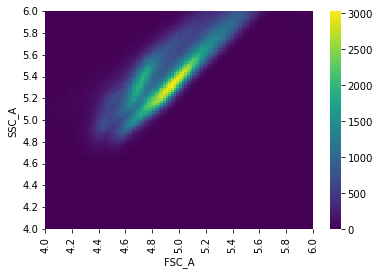

In [26]:
ax = sns.heatmap(x, cbar=True, cmap='viridis')
ticklabels = [f"{x:.1f}" for x in [4 + 0.2 * x for x in range(0, 11)]]
ticks = np.array([10 * x for x in range(0, 11)])
print(ticks)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticklabels)
ticklabels.reverse()
ax.set_yticklabels(ticklabels)

A python function to do the plotting and axis labeling.

In [27]:
def make_heatmap(histo: pd.DataFrame) -> mpl.axes.Axes:
    """
    Plot a Pandas `DataFrame`, built by `point_cloud_to_histogram`
    as a Seaborn heatmap.
    
    Notes
    ~~~~~
    The technique for labeling the Axes of the histogram was culled
    from StackExchange: https://stackoverflow.com/a/65970580/289934
    """
    ax = sns.heatmap(x, cbar=True, cmap='viridis')
    ticklabels = [f"{x:.1f}" for x in [4 + 0.2 * x for x in range(0, 11)]]
    ticks = np.array([10 * x for x in range(0, 11)])
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticklabels)
    ticklabels.reverse()
    ax.set_yticklabels(ticklabels)
    return ax

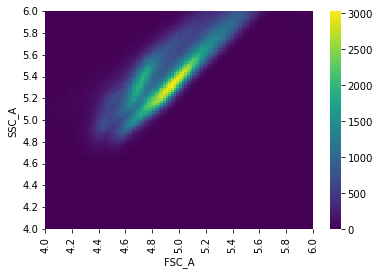

In [28]:
make_heatmap(x);

In [125]:
reload(plot_helpers)

<module 'plot_helpers' from '/Users/rpg/projects/xplan/hpc-notebooks/plot_helpers.py'>

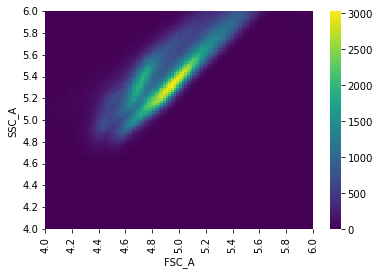

In [96]:
import plot_helpers
x = plot_helpers.point_cloud_to_histogram(df, logscale=True)
plot_helpers.make_heatmap(x, logscale=True);

# Now plot raw data

In [126]:
x = plot_helpers.point_cloud_to_histogram(df, logscale=False)
x

FSC_A,-100000,-90000,-80000,-70000,-60000,-50000,-40000,-30000,-20000,-10000,...,900000,910000,920000,930000,940000,950000,960000,970000,980000,990000
SSC_A,,,,,,,,,,,,,,,,,,,,,
990000,0,0,0,0,0,0,0,0,0,0,...,0,1,3,1,1,3,0,2,0,0
980000,0,0,0,0,0,0,0,0,0,0,...,1,3,0,0,1,0,0,0,2,1
970000,0,0,0,0,0,0,0,0,0,0,...,3,1,2,0,2,1,0,1,1,1
960000,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,3,1,0,1
950000,0,0,0,0,0,0,0,0,0,0,...,2,1,1,2,1,2,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-60000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
-70000,0,0,0,7,0,0,0,0,0,0,...,9,7,7,4,11,7,6,5,4,4
-80000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
len(x.columns)

110

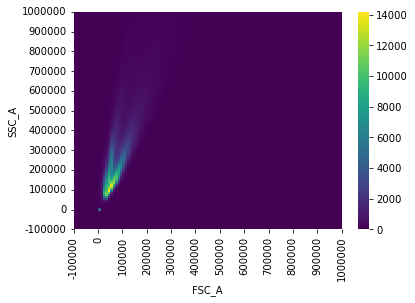

In [128]:
plot_helpers.make_heatmap(x, logscale=False);

An earlier, abortive attempt.  I tried to use a numpy 2D histogram, but it was a lot more cumbersome to work with than a DataFrame.

4.0
<class 'numpy.ndarray'>


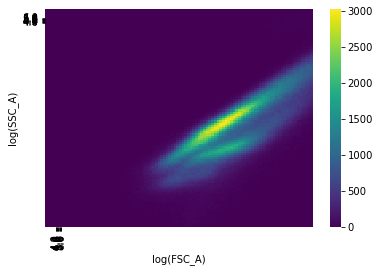

In [36]:
def failed_sns_heatmap(idf):
    df = idf.query('FSC_A > 0 and SSC_A > 0')
    xs = np.log10(df['FSC_A']+1)
    ys = np.log10(df['SSC_A']+1)
    heatmap, xedges, yedges = np.histogram2d(xs, ys, bins=100, range=[[4, 6], [4, 6]])
    print(xedges[0])
    width = xedges[1] - xedges[0]
    print(type(xedges))
    ax = sns.heatmap(np.flipud(heatmap), cbar=True, cmap='viridis')
#                     xticklabels=)
    ax.set_xlabel('log(FSC_A)'); ax.set_ylabel('log(SSC_A)')
    ticks = np.array([4 + 0.2 * x for x in range(0, 11)])
    ax.set_xticks(ticks)
    ax.set_xticklabels([f'{(4.0 + x * 0.2):.1f}' for x in range(0, 11)])
    ax.set_yticks(ticks)
    yticklabels = [f'{(4.0 + x * 0.2):.1f}' for x in range(0, 11)]
    yticklabels.reverse()
    ax.set_yticklabels(yticklabels)
#     #b, a = np.meshgrid(np.linspace(0, 1_000_000, 1000), np.linspace(0, 1_000_000, 1000))
#     g = sns.JointGrid(data=df, x="FSC_A", y="SSC_A")
#     g.ax_joint.set(yscale='log', xscale='log')
#     # Create an inset legend for the histogram colorbar
#     cax = g.fig.add_axes([.15, .55, .02, .2])
#     print(mpl.cm.get_cmap('viridis'))
#     print(sns.color_palette('viridis', as_cmap=True))
#     sns.color_palette("viridis", as_cmap=True)
#     g.plot_joint(sns.histplot, 
#                  palette=sns.color_palette("viridis"),
#                  cbar=True, cbar_ax=cax, alpha=1,
#                  bins=(100, 100), binrange=((4, 6), (4, 6)))

failed_sns_heatmap(df)

# Forward Scatter Area as a function of incubation time (`inc_time_2`)

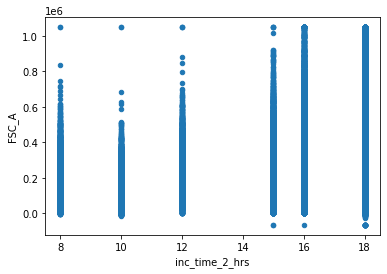

In [37]:
df.reset_index(level='inc_time_2_hrs', drop=False).plot.scatter(x='inc_time_2_hrs', y='FSC_A');

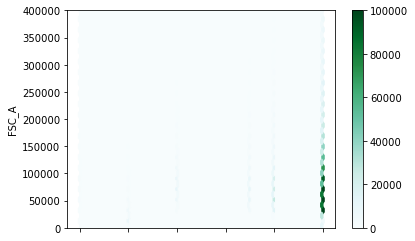

In [38]:
ax = df.reset_index(level='inc_time_2_hrs', drop=False).plot.hexbin(x='inc_time_2_hrs', y='FSC_A', vmax=100_000);
ax.set_ylim(0, 400_000);

## Plotting incubation times separately

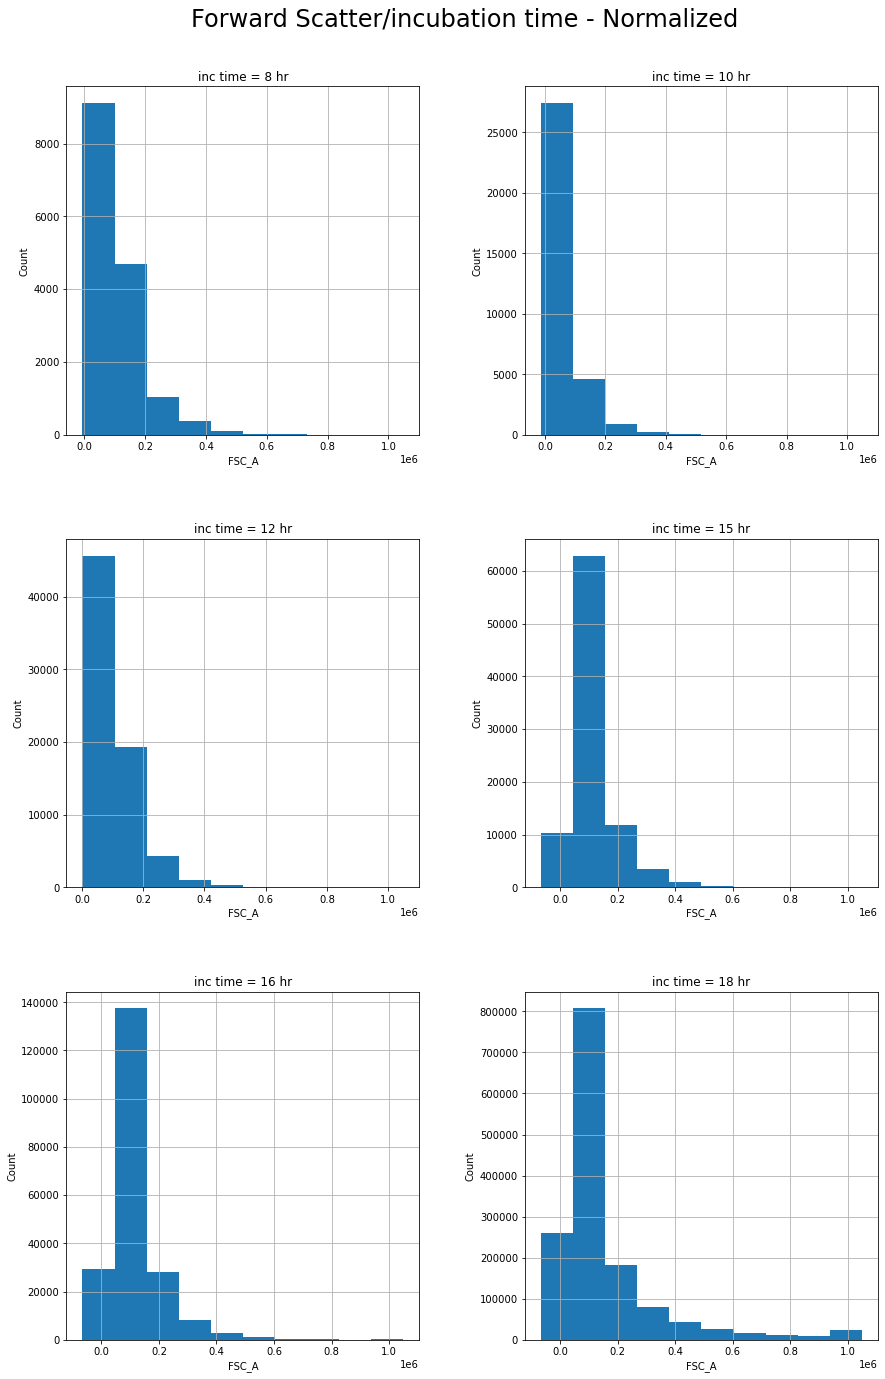

In [39]:
fig, axeses = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(axeses.shape[1] * 6, axeses.shape[0] * 6)
fig.tight_layout()
axeses = axeses.flatten()
i = 0
for group_name, df_group in df.groupby('inc_time_2_hrs'):
    ax = axeses[i]
    df_group.hist(column='FSC_A', ax=axeses[i])
    ax.set_title(f'inc time = {group_name} hr')
    ax.set_xlabel('FSC_A')
    ax.set_ylabel('Count')
    i += 1
fig.suptitle('Forward Scatter/incubation time - Normalized', y=1.05, fontsize=24);

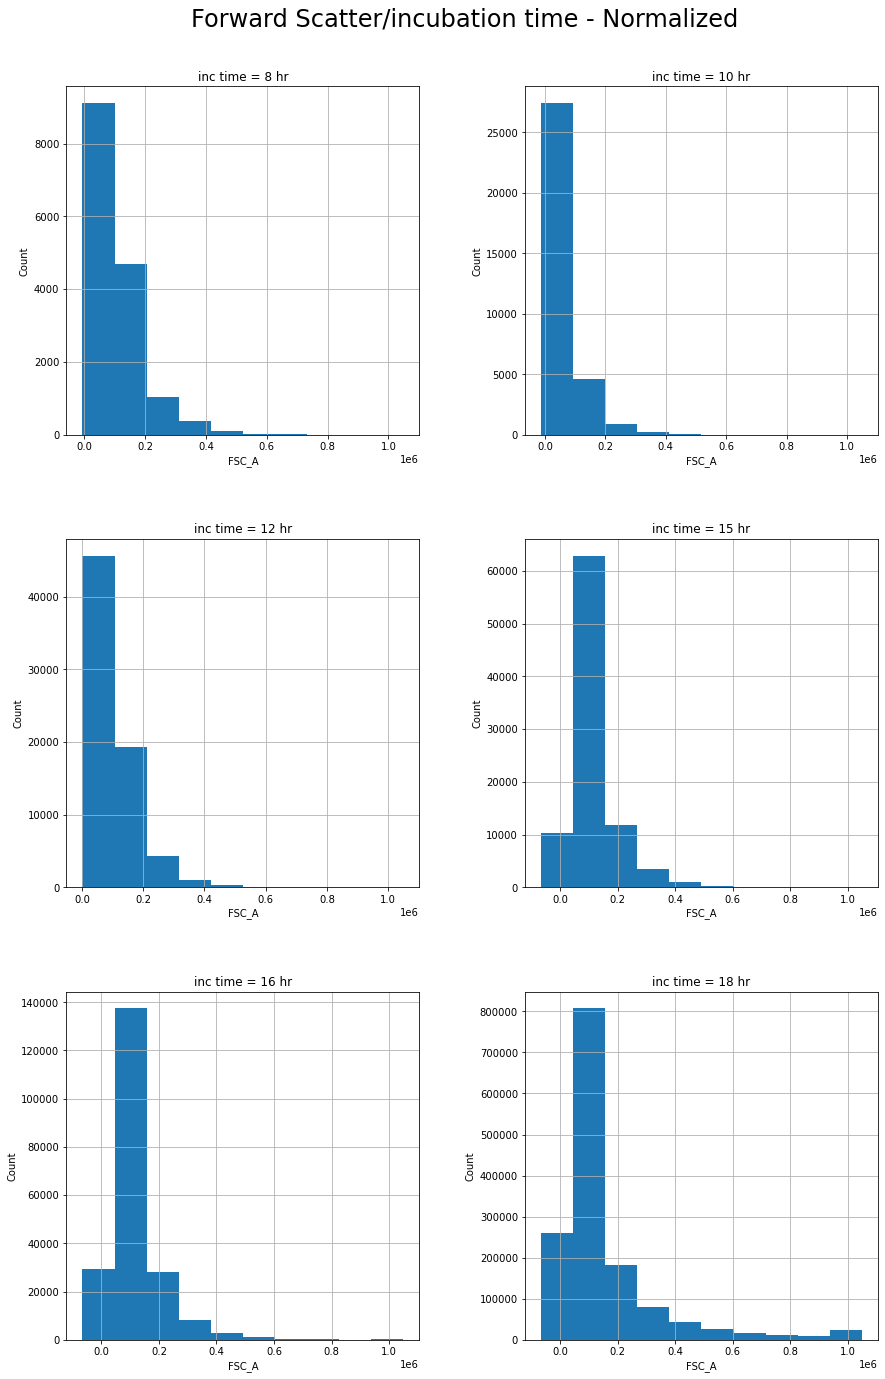

In [40]:
fig, axeses = plt.subplots(nrows=3, ncols=2)
fig.set_size_inches(axeses.shape[1] * 6, axeses.shape[0] * 6)
fig.tight_layout()
axeses = axeses.flatten()
i = 0
for group_name, df_group in df.groupby('inc_time_2_hrs'):
    ax = axeses[i]
    df_group.hist(column='FSC_A', ax=axeses[i])
    ax.set_title(f'inc time = {group_name} hr')
    ax.set_xlabel('FSC_A')
    ax.set_ylabel('Count')
    i += 1
fig.suptitle('Forward Scatter/incubation time - Normalized', y=1.05, fontsize=24);

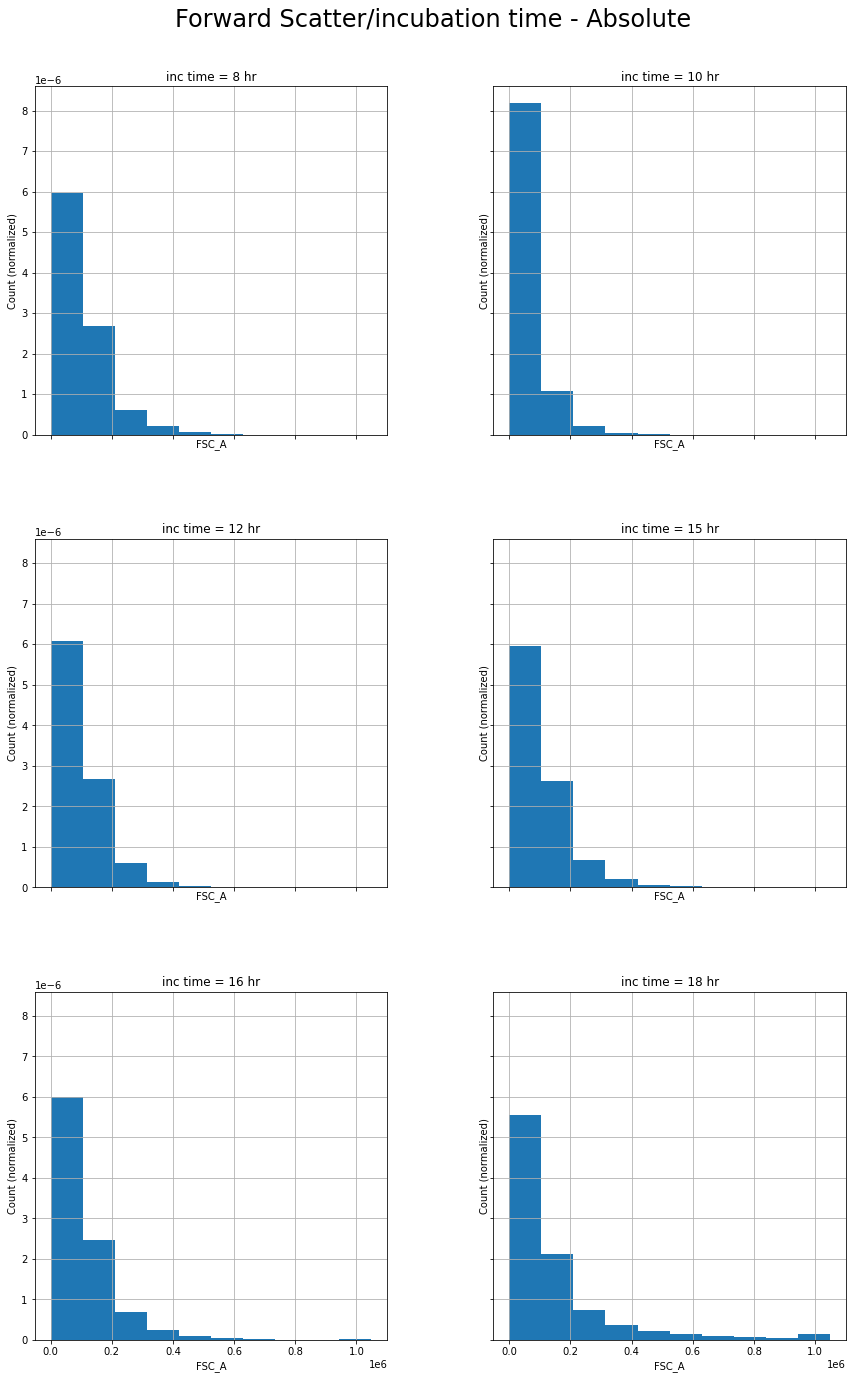

In [41]:
fig, axeses = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True)
fig.set_size_inches(axeses.shape[1] * 6, axeses.shape[0] * 6)
fig.tight_layout()
axeses = axeses.flatten()
i = 0
for group_name, df_group in df.groupby('inc_time_2_hrs'):
    ax = axeses[i]
    df_group.hist(column='FSC_A', ax=axeses[i], range=(0, df_group['SSC_A'].max()), density=True)
    ax.set_title(f'inc time = {group_name} hr')
    ax.set_xlabel('FSC_A')
    ax.set_ylabel('Count (normalized)')
    i += 1
    
fig.suptitle('Forward Scatter/incubation time - Absolute', y=1.05, fontsize=24);

# Considering both incubation times

In [42]:
for group_name, df_group in df.groupby(['inc_time_1_hrs','inc_time_2_hrs']):
    print(group_name)


(16, 16)
(18, 8)
(18, 10)
(18, 12)
(18, 15)
(18, 16)
(18, 18)


## Plotting incubation times separately

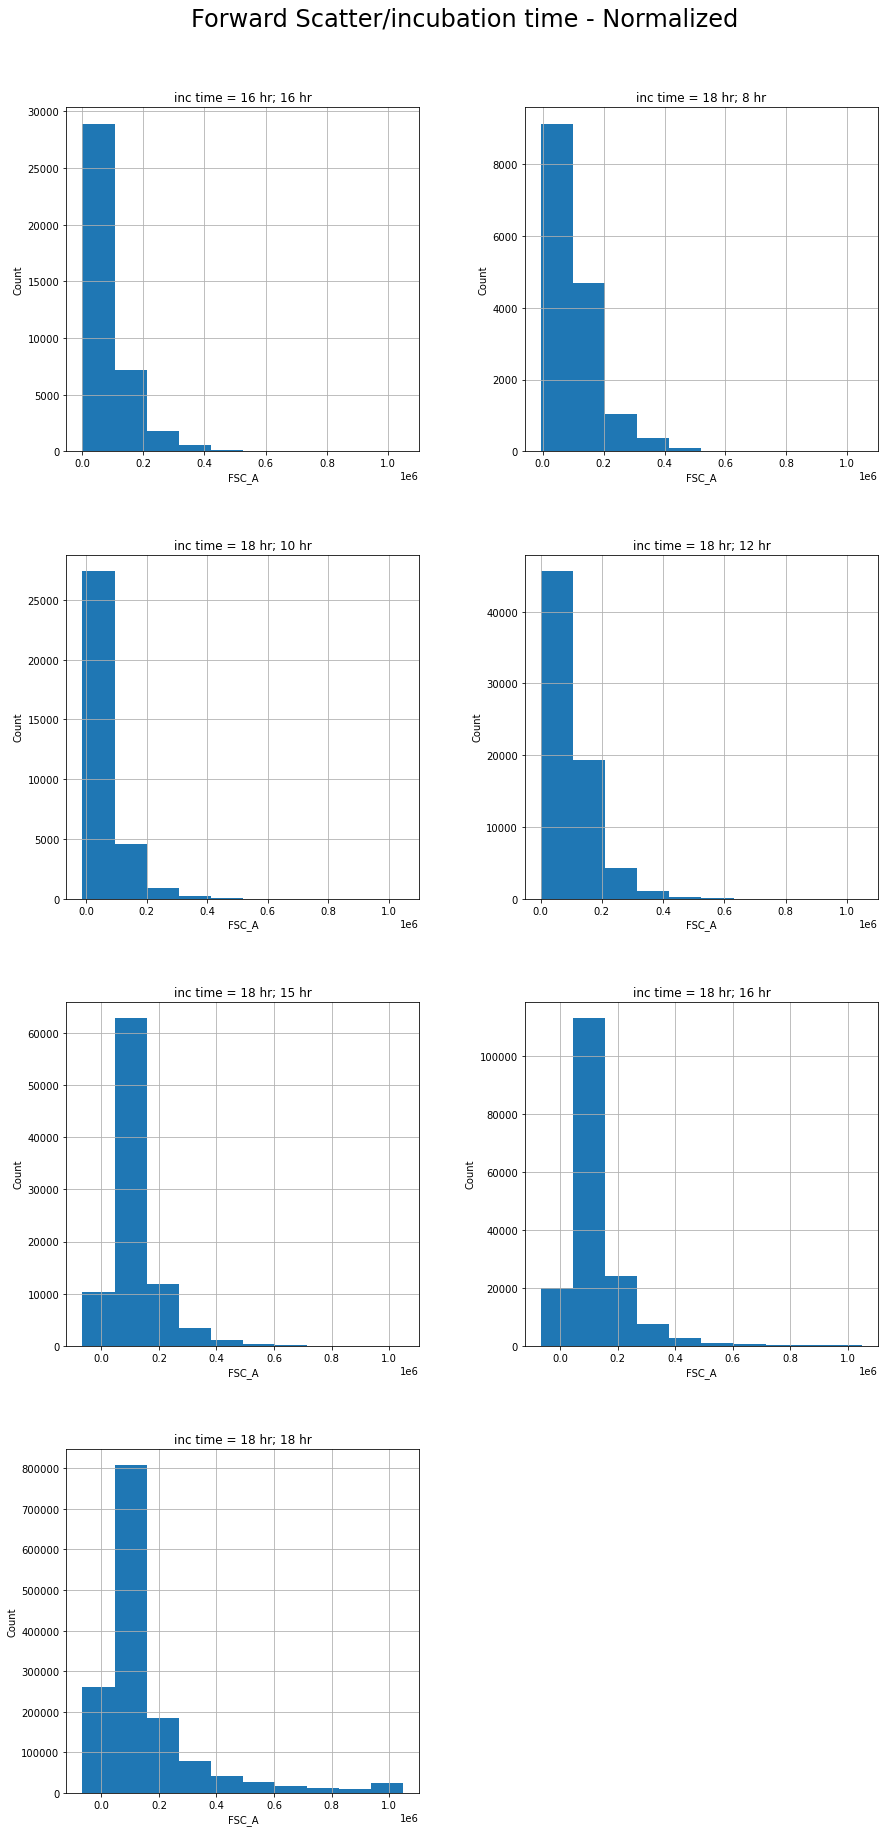

In [43]:
fig, axeses = plt.subplots(nrows=4, ncols=2)
fig.delaxes(axeses[3][1])
fig.set_size_inches(axeses.shape[1] * 6, axeses.shape[0] * 6)
fig.tight_layout()
axeses = axeses.flatten()
i = 0
for group_name, df_group in df.groupby(['inc_time_1_hrs','inc_time_2_hrs']):
    ax = axeses[i]
    df_group.hist(column='FSC_A', ax=axeses[i])
    ax.set_title(f'inc time = {group_name[0]} hr; {group_name[1]} hr')
    ax.set_xlabel('FSC_A')
    ax.set_ylabel('Count')
    i += 1
fig.suptitle('Forward Scatter/incubation time - Normalized', y=1.05, fontsize=24);

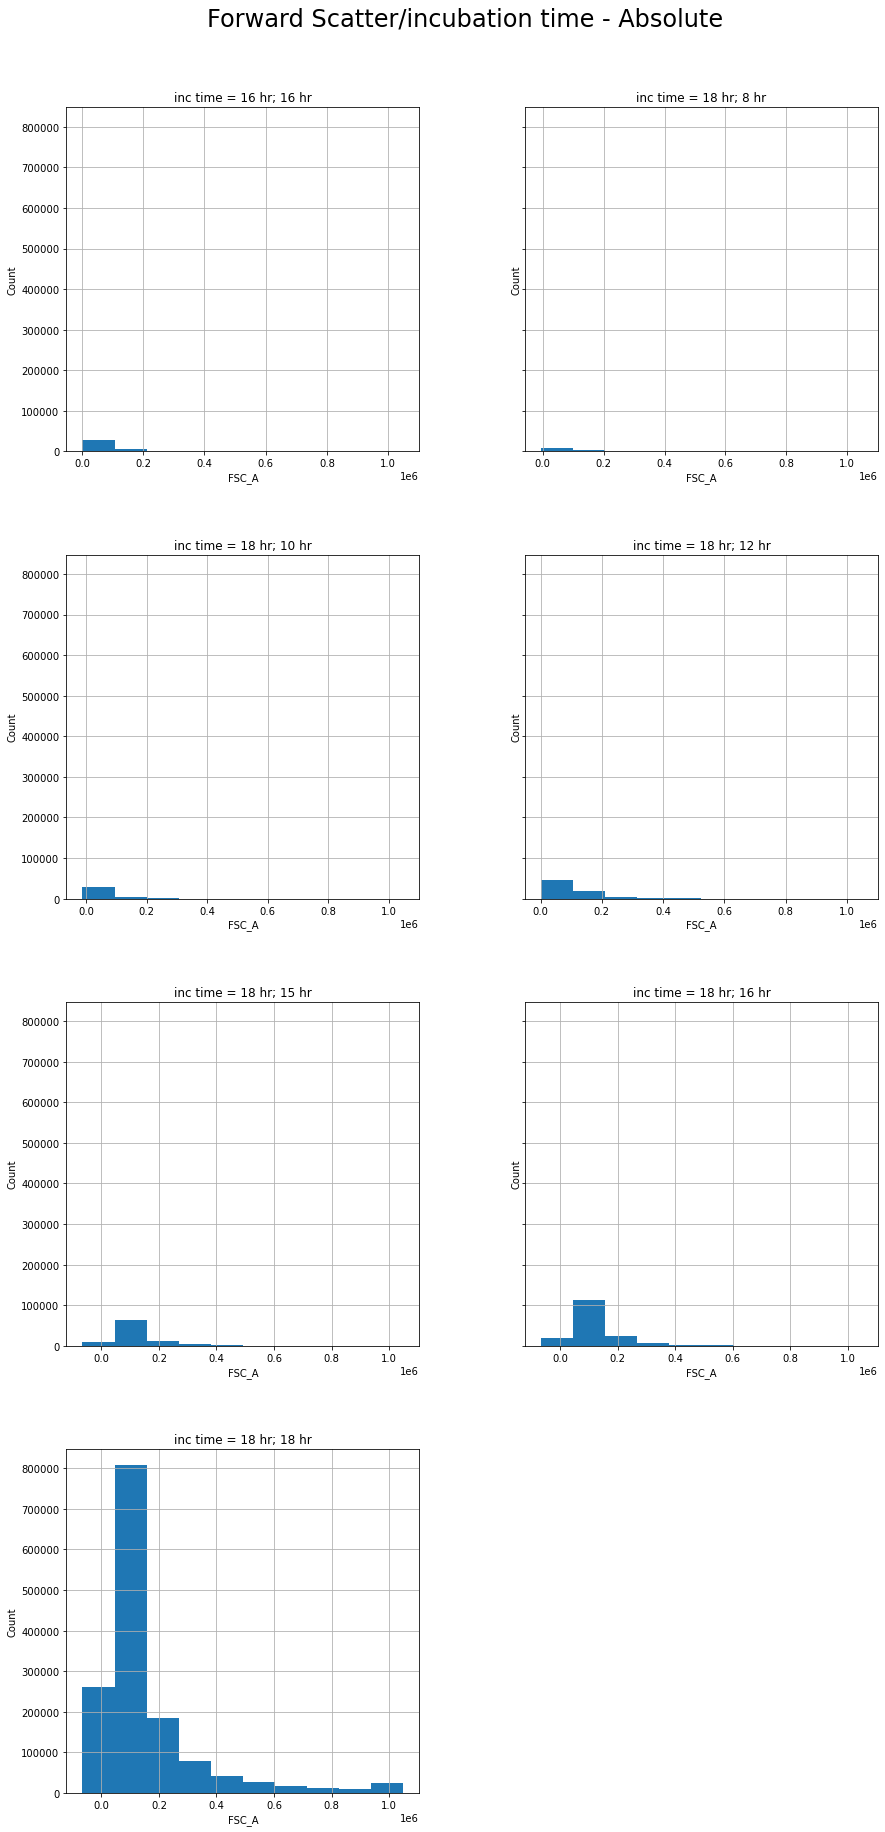

In [44]:
fig, axeses = plt.subplots(nrows=4, ncols=2, sharey=True)
fig.set_size_inches(axeses.shape[1] * 6, axeses.shape[0] * 6)
fig.delaxes(axeses[3][1])
fig.tight_layout()
axeses = axeses.flatten()
i = 0
for group_name, df_group in df.groupby(['inc_time_1_hrs','inc_time_2_hrs']):
    ax = axeses[i]
    df_group.hist(column='FSC_A', ax=axeses[i])
    ax.set_title(f'inc time = {group_name[0]} hr; {group_name[1]} hr')
    ax.set_xlabel('FSC_A')
    ax.set_ylabel('Count')
    i += 1
    
fig.suptitle('Forward Scatter/incubation time - Absolute', y=1.05, fontsize=24);

# Focus on 18 hour incubation time

This case has so much more data than any of the others that we should probably focus on it when making any gating decisions.

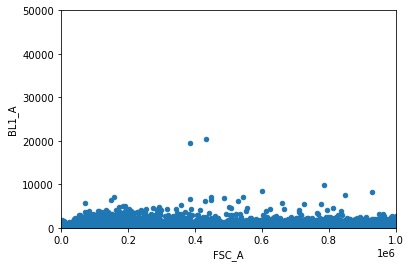

In [45]:
ax = df.query('inc_time_2_hrs == 18').plot.scatter(x='FSC_A', y='BL1_A')
ax.set_xlim(0, 1_000_000)
ax.set_ylim(0, 50_000);

In [46]:
df.query('inc_time_2_hrs == 18')[['FSC_A', 'SSC_A', 'BL1_A']].describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])

,FSC_A,SSC_A,BL1_A
count,1.462598e+06,1.462598e+06,1.462598e+06
mean,1.551651e+05,4.286410e+05,7.673012e+01
std,1.867880e+05,3.268497e+05,6.456020e+02
min,-6.553600e+04,-6.553600e+04,-3.709000e+03
25%,5.269600e+04,1.732020e+05,-9.000000e+00
50%,8.699950e+04,2.976950e+05,4.100000e+01
75%,1.688520e+05,6.233215e+05,1.060000e+02
80%,2.058566e+05,7.661076e+05,1.280000e+02
85%,2.608890e+05,9.796469e+05,1.590000e+02
90%,3.542479e+05,1.048575e+06,2.130000e+02


## Side scatter measurements

The above chart shows that there are a number of SSC_A measurements that are substantially less than zero.  Does this suggest that the cytometer was not well-calibrated for side-scatter?  At any rate, am I correct in assuming we should gate out any events with SSC_A $\leq 0$?  This wouldn't be a substantial number of samples -- just 0.6%.

In [47]:
df.query('inc_time_2_hrs == 18 and SSC_A <= 0')['SSC_A'].describe()

count     6635.000000
mean     -9449.146797
std      19000.584051
min     -65536.000000
25%      -5037.500000
50%      -2391.000000
75%      -1106.500000
max         -2.000000
Name: SSC_A, dtype: float64

In [48]:
df.query('inc_time_2_hrs == 18')['SSC_A'].describe()

count    1.462598e+06
mean     4.286410e+05
std      3.268497e+05
min     -6.553600e+04
25%      1.732020e+05
50%      2.976950e+05
75%      6.233215e+05
max      1.048575e+06
Name: SSC_A, dtype: float64

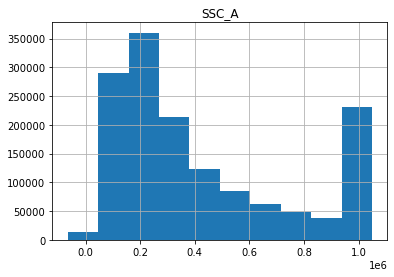

In [49]:
ax = df.query('inc_time_2_hrs == 18').hist(column='SSC_A')
#ax.set_xlim(0, 1_000_000)
#ax.set_ylim(0, 50_000);

## Single channel bound gating

Based on the above, we propose single channel gating as follows:

* $0 \leq$ **FSC_A** $< 900,000$
* $0 \leq$ **SSC_A** $< 900,000$
* $0 \leq$ **BL1_A** $< 20,000$

Values outside those ranges are likely to be mis-calibrated or otherwise outliers.

## Looking for sub-populations

Plotting Forward and Side-scatter to see if anything jumps out in terms of sub-populations.  Most of the population is very dispersed, but there's a definite chunk of the events that are small and that are correlated with having low fluorescence.

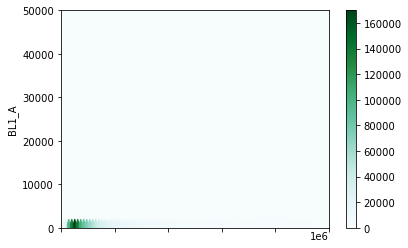

In [50]:
ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='BL1_A')
ax.set_xlim(0, 1_000_000)
ax.set_ylim(0, 50_000);

In [51]:
df.query('inc_time_2_hrs == 18')[['FSC_A', 'SSC_A']].describe()

,FSC_A,SSC_A
count,1.462598e+06,1.462598e+06
mean,1.551651e+05,4.286410e+05
std,1.867880e+05,3.268497e+05
min,-6.553600e+04,-6.553600e+04
25%,5.269600e+04,1.732020e+05
50%,8.699950e+04,2.976950e+05
75%,1.688520e+05,6.233215e+05
max,1.048575e+06,1.048575e+06


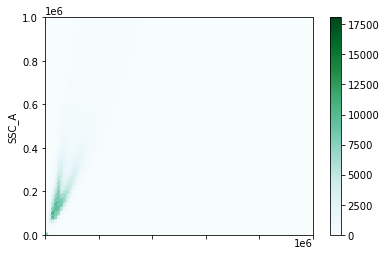

In [52]:
ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='SSC_A');
ax.set_xlim(0, 1_000_000); ax.set_ylim(0, 1_000_000);

In [53]:
def heatmap(idf, query, 
            xdata='FSC_A', ydata='SSC_A',
            cmap=None,
            logscale=False, 
            xrange=None, yrange=None):
    df = idf.query(query)
    xs = df[xdata]
    ys = df[ydata]
    if logscale:
        xs = np.log10(xs + 1)
        ys = np.log10(ys + 1)
        xrange = xrange or [0, 6]
        yrange = yrange or [0, 6]
    else:
        xrange = xrange or [0, 1_000_000]
        yrange = yrange or [0, 1_000_000]        
    heatmap, xedges, yedges = np.histogram2d(xs, 
                                             ys, 
                                             bins=100, 
                                             range=[xrange, yrange]
                                            )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax = plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap)
    plt.xlabel(f'log10 {xdata}' if logscale else xdata)
    plt.ylabel(f'log10 {ydata}' if logscale else ydata)
    figure = plt.gcf()
    figure.colorbar(ax)
    # figure, axes = plt.subplots()
    # c = np.stack((np.array(df['FSC_A']), np.array(df['SSC_A'])), axis=1)
    # print(c.shape)
    # plot = axes.pcolormesh(a, b, c, cmap='cool_r', vmin=0, vmax=1_000_000)
    # figure.colorbar(plot)
    # plt.show()


(-65536.0, 1100000) (-65536.0, 1100000)


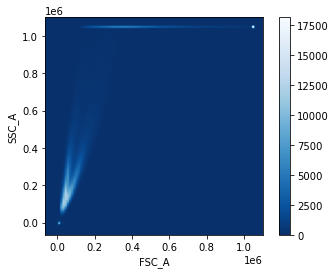

In [54]:
def cellfunc(idf):
    df = idf
    query = 'inc_time_2_hrs == 18'
    filtered = df.query(query)
    maxval = 1_100_000
    xrange = df['FSC_A'].min(), maxval
    yrange = df['SSC_A'].min(), maxval

    heatmap(df, query=query, xrange=xrange, yrange=yrange, cmap='Blues_r')
    print(xrange, yrange)
    
cellfunc(df)
# ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='SSC_A');
# ax.set_xlim(0, 1_000_000); ax.set_ylim(0, 1_000_000);

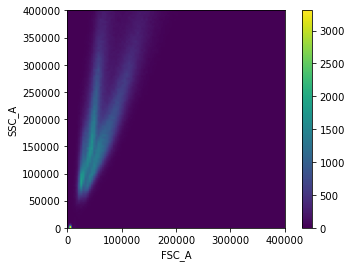

In [55]:
heatmap(df, query='inc_time_2_hrs == 18', xrange=[0, 400_000], yrange=[0, 400_000])

/Users/rpg/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


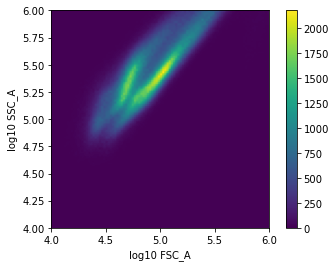

In [56]:
heatmap(df, query='inc_time_2_hrs == 18', logscale=True, xrange=[4, 6], yrange=[4,6])

Plotting hexbin heatmaps. These seem to make reviewers unhappy.

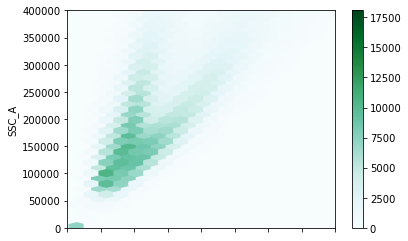

In [57]:
ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='SSC_A');
ax.set_xlim(0, 200_000); ax.set_ylim(0, 400_000);

Heatmap rescaled to make the two shapes clearer.

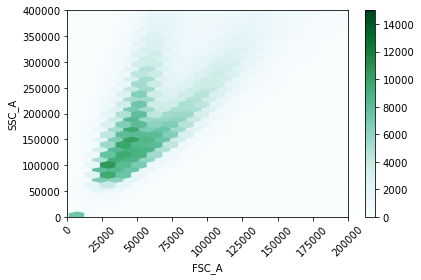

In [58]:
ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='SSC_A', vmax=15_000);
fig = ax.figure
ax.set_xlim(0, 200_000); ax.set_ylim(0, 400_000);
xaxis = ax.get_xaxis()
xaxis.set_label_text('FSC_A', visible=True)
#ax.tick_params(axis='x',which='major')
xaxis.set_ticks(range(0, 200_001, 25_000))
#print(ax.get_xticks())
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
#print([str(int(x)) for x in ax.get_xticks()])
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, rotation=45, labeltop=False)
#lst = ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()], visible=True, rotation=45)
#print(ax.get_xticklabels())
#print(lst)
fig.tight_layout()



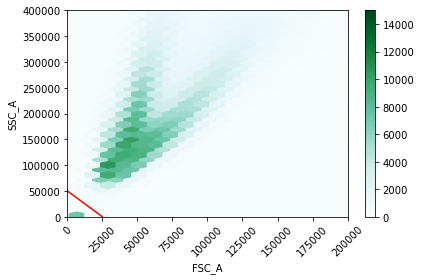

In [59]:
ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='SSC_A', vmax=15_000);
fig = ax.figure
ax.set_xlim(0, 200_000); ax.set_ylim(0, 400_000);
xaxis = ax.get_xaxis()
xaxis.set_label_text('FSC_A', visible=True)
#ax.tick_params(axis='x',which='major')
xaxis.set_ticks(range(0, 200_001, 25_000))
#print(ax.get_xticks())
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
#print([str(int(x)) for x in ax.get_xticks()])
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, rotation=45, labeltop=False)
#lst = ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()], visible=True, rotation=45)
#print(ax.get_xticklabels())
#print(lst)
ax.axline((25_000, 0), (0, 50_000), color='red')
#ax.axline((25_000, 0), (0, 50_000))

fig.tight_layout()



In [60]:
data_points = df.query('inc_time_2_hrs == 18 and SSC_A < 400_000 and FSC_A < 150_000')[['FSC_A', 'SSC_A']].to_numpy()

In [61]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data_points)

In [62]:
scaled[0:10, :]

array([[ 0.62657898,  0.13321301],
       [ 0.21985748,  0.53011999],
       [ 0.49681195,  0.14637103],
       [ 0.77734413, -0.72754801],
       [ 1.29962214,  0.28365676],
       [ 1.23191325,  0.13958785],
       [-0.1849247 , -0.61936871],
       [ 1.17129288,  0.49125847],
       [ 2.43535949,  1.72012631],
       [ 1.03055869, -0.53664337]])

In [63]:
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [64]:
kmeans.fit(scaled)

KMeans(init='random', n_clusters=5, random_state=42)

In [65]:
kmeans.cluster_centers_

array([[ 0.76750581,  0.10195388],
       [ 1.80371021,  1.31688616],
       [-1.05715463, -1.21386203],
       [-0.11679856,  1.18156669],
       [-0.39853818, -0.36128235]])

In [66]:
scaler.inverse_transform(kmeans.cluster_centers_)

array([[ 87743.76117255, 213916.2201673 ],
       [118733.98501882, 321023.67255066],
       [ 33172.83302379,  97914.94675334],
       [ 61296.47855737, 309094.01686142],
       [ 52870.36686007, 173077.68636709]])

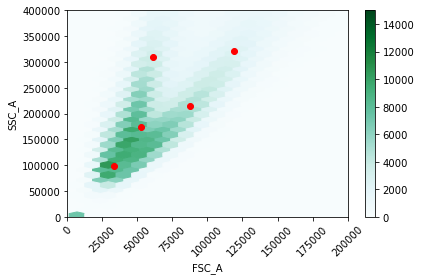

In [67]:
ax = df.query('inc_time_2_hrs == 18').plot.hexbin(x='FSC_A', y='SSC_A', vmax=15_000);
fig = ax.figure
ax.set_xlim(0, 200_000); ax.set_ylim(0, 400_000);
xaxis = ax.get_xaxis()
xaxis.set_label_text('FSC_A', visible=True)
#ax.tick_params(axis='x',which='major')
xaxis.set_ticks(range(0, 200_001, 25_000))
#print(ax.get_xticks())
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
#print([str(int(x)) for x in ax.get_xticks()])
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, rotation=45, labeltop=False)
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
ax.scatter(centroids[:, 0], centroids[:, 1], color='red')
#lst = ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()], visible=True, rotation=45)
#print(ax.get_xticklabels())
#print(lst)
fig.tight_layout()



## Zoom in to find bounds on debris cluster

There are 4247 events in the debris cluster area out of 1462598.


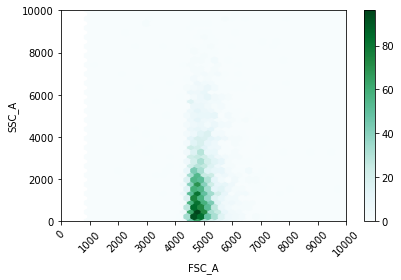

In [68]:
small_datapoints = df.query('inc_time_2_hrs == 18 and 0 <= SSC_A <= 25_000 and 0 <= FSC_A < 25_000')
print(f'There are {small_datapoints.shape[0]} events in the debris cluster area out of {df.query("inc_time_2_hrs == 18").shape[0]}.')
ax = small_datapoints.plot.hexbin(x='FSC_A', y='SSC_A');
fig = ax.figure
ax.set_xlim(0, 10_000); ax.set_ylim(0, 10_000);
xaxis = ax.get_xaxis()
xaxis.set_label_text('FSC_A', visible=True)
#ax.tick_params(axis='x',which='major')
xaxis.set_ticks(range(0, 10_001, 1000))
#print(ax.get_xticks())
#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)
#print([str(int(x)) for x in ax.get_xticks()])
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, rotation=45, labeltop=False)
#lst = ax.set_xticklabels([str(int(x)) for x in ax.get_xticks()], visible=True, rotation=45)
#print(ax.get_xticklabels())
#print(lst)
fig.tight_layout()



# Gating out the debris cluster
From the above, it looks like even an aggressive gate at 50,000 on the two scatter channels would safely get rid of the debris cluster without a lot of false positives, but we should examine the implications for this that we see in the negative controls, before applying them.  Here we do so, by focusing on only those events with very low scatter measurements.

In [69]:
df.query('inc_time_2_hrs == 18 and FSC_A < 50_000 and SSC_A < 50_000')[['FSC_A', 'SSC_A', 'BL1_A']].describe()

,FSC_A,SSC_A,BL1_A
count,12839.000000,12839.000000,12839.000000
mean,9606.075551,8575.707142,33.676688
std,9300.111378,18134.399293,1678.790593
min,-65536.000000,-65536.000000,-265.000000
25%,4754.000000,-1855.500000,-28.000000
50%,5068.000000,371.000000,0.000000
75%,6792.500000,5849.000000,29.000000
max,49968.000000,49999.000000,139932.000000


In [70]:
df.query('inc_time_2_hrs == 18 and FSC_A < 50_000 and SSC_A < 50_000')[['FSC_A', 'SSC_A', 'BL1_A']].describe(percentiles=[.75, .8, .85, .90, .95])

,FSC_A,SSC_A,BL1_A
count,12839.000000,12839.000000,12839.000000
mean,9606.075551,8575.707142,33.676688
std,9300.111378,18134.399293,1678.790593
min,-65536.000000,-65536.000000,-265.000000
50%,5068.000000,371.000000,0.000000
75%,6792.500000,5849.000000,29.000000
80%,15936.400000,28194.600000,36.000000
85%,21035.300000,39543.600000,44.000000
90%,25572.000000,44604.000000,55.000000
95%,31197.300000,47636.000000,72.000000


The above suggests that a less aggressive gate at FSC_A < 15,000 and SSC_A < 20,000 would probably be appropriate.  

The following tables aim to see how much data would be sacrificed by this less aggressive gate (not much).  They also identify where it seems like the true outliers start.  For exmaple in the first chart, the distance between the 75th percentile and the max is large for the two scatter channels and BL1_A fluorescence.

In [71]:
df.query('inc_time_2_hrs == 18 and FSC_A < 15_000 and SSC_A < 20_000')[['FSC_A', 'SSC_A', 'BL1_A']].describe()

,FSC_A,SSC_A,BL1_A
count,9861.000000,9861.000000,9861.000000
mean,5152.741406,-724.543758,41.513031
std,2240.538419,4031.763650,1915.263502
min,-65536.000000,-65536.000000,-198.000000
25%,4697.000000,-2423.000000,-28.000000
50%,4907.000000,-587.000000,-1.000000
75%,5221.000000,1169.000000,25.000000
max,14993.000000,19947.000000,139932.000000


In [72]:
df.query('inc_time_2_hrs == 18')[['FSC_A', 'SSC_A', 'BL1_A']].describe()

,FSC_A,SSC_A,BL1_A
count,1.462598e+06,1.462598e+06,1.462598e+06
mean,1.551651e+05,4.286410e+05,7.673012e+01
std,1.867880e+05,3.268497e+05,6.456020e+02
min,-6.553600e+04,-6.553600e+04,-3.709000e+03
25%,5.269600e+04,1.732020e+05,-9.000000e+00
50%,8.699950e+04,2.976950e+05,4.100000e+01
75%,1.688520e+05,6.233215e+05,1.060000e+02
max,1.048575e+06,1.048575e+06,3.848500e+05


In [73]:
df.query('inc_time_2_hrs == 18 and FSC_A >= 15_000 and SSC_A >= 20_000')[['FSC_A', 'SSC_A', 'BL1_A']].describe()

,FSC_A,SSC_A,BL1_A
count,1.450183e+06,1.450183e+06,1.450183e+06
mean,1.560066e+05,4.322483e+05,7.589121e+01
std,1.865301e+05,3.258701e+05,4.263834e+02
min,1.500600e+04,2.000600e+04,-3.709000e+03
25%,5.324200e+04,1.756020e+05,-8.000000e+00
50%,8.770800e+04,3.005230e+05,4.200000e+01
75%,1.698005e+05,6.283490e+05,1.060000e+02
max,1.048575e+06,1.048575e+06,2.546950e+05


# Events per experimental well

Do we get the full number of events from each experimental well?  If not, what does this tell us, and should we use this information to filter the data?

In [74]:
len(df['lab_id'].unique())

75

In [75]:
df.shape[0] / len(df['lab_id'].unique())

25067.81333333333

In [76]:
ser = df.groupby('lab_id')['id'].count()
ser.name = 'Event count'
with pd.option_context('display.max_rows', None):
    print(ser.sort_values())

lab_id
r1cwvvxz5d7wua_r1cx7ucsnkjfsb      194
r1cwvvvj2bh6hc_r1cx4pbeyv2q29      358
r1d6r59sste9m2_r1d8gf8cczkrz9     1772
r1d6r5b24f9a9z_r1d8cyvjthnvvt     2065
r1d6r58jnct63g_r1d8kxz5ndkxyh     2430
r1ce3p3p7j77n_r1ceevbnsqku2       2625
r1c5vac658fxn_r1c66qw595ydy       4335
r1c5vad8u7ve2_r1c66q7cru28u       4335
r1c7cpqp2k6cw_r1c7jn9syrr8s       4335
r1cbuszfskzjt_r1cc6ws9c3dh4       5162
r1d6r8mvznxxme_r1d8jxmssfag5w     7534
r1cwvvwryt3q49_r1cx4ux3zcdt4w     8511
r1cbut6a79n9t_r1cc34mkuvzeh      10476
r1d6r8ztq8zfa7_r1d952nn9xk753    10580
r1cgbw9ww9g9h_r1cgjg8e8xeav      19747
r1d6r8p5ddgsut_r1d8fgr2efzrhj    25627
r1ceuhrtvgyvd_r1cf6kx2a233e      30000
r1ceuhu9enre5_r1cf33y4j6dyg      30000
r1cfkpuz2kr6c_r1cfpvk5hjkzb      30000
r1ceuhvgf7b4y_r1cf2yr353x5j      30000
r1cf3p48cauwv_r1cf6hech88mh      30000
r1cfkpp2p3kjz_r1cftpr8wxqc7      30000
r1cfkpq8n84aj_r1cftg78pbqd7      30000
r1cfkprehr2fj_r1cft8f7cbsp7      30000
r1cfkptta6kuc_r1cfq4k72rwba      30000
r1cft9f659y9s_r1cf

In [77]:
events_df = df.reset_index('inc_time_2_hrs', drop=False).groupby('lab_id')[['id', 'inc_time_1_hrs', 'inc_time_2_hrs']].agg({'id': 'count', 'inc_time_1_hrs': 'first', 'inc_time_2_hrs': 'first'})
events_df =events_df.rename(columns={'id': 'events'}).sort_values(by='events')                                                                     
# ser.name = 'Event count'
with pd.option_context('display.max_rows', None):
     print(events_df)

                               events  inc_time_1_hrs  inc_time_2_hrs
lab_id                                                               
r1cwvvxz5d7wua_r1cx7ucsnkjfsb     194              18               8
r1cwvvvj2bh6hc_r1cx4pbeyv2q29     358              18               8
r1d6r59sste9m2_r1d8gf8cczkrz9    1772              18               8
r1d6r5b24f9a9z_r1d8cyvjthnvvt    2065              18               8
r1d6r58jnct63g_r1d8kxz5ndkxyh    2430              18               8
r1ce3p3p7j77n_r1ceevbnsqku2      2625              18              18
r1c5vac658fxn_r1c66qw595ydy      4335              16              16
r1c5vad8u7ve2_r1c66q7cru28u      4335              16              16
r1c7cpqp2k6cw_r1c7jn9syrr8s      4335              18              18
r1cbuszfskzjt_r1cc6ws9c3dh4      5162              18              18
r1d6r8mvznxxme_r1d8jxmssfag5w    7534              18              10
r1cwvvwryt3q49_r1cx4ux3zcdt4w    8511              18               8
r1cbut6a79n9t_r1cc34

## Further filtering
The above suggests we should reject out of hand replicates with event counts less than 10K (value suggested by Rob Moseley), and probably ignore all data for the second incubation time less than 10, since none of the 8 hour replicates has a full set of samples.

In [78]:
bad_replicates = events_df[events_df['events'] < 10_000].reset_index(drop=False)['lab_id']
bad_replicates

0     r1cwvvxz5d7wua_r1cx7ucsnkjfsb
1     r1cwvvvj2bh6hc_r1cx4pbeyv2q29
2     r1d6r59sste9m2_r1d8gf8cczkrz9
3     r1d6r5b24f9a9z_r1d8cyvjthnvvt
4     r1d6r58jnct63g_r1d8kxz5ndkxyh
5       r1ce3p3p7j77n_r1ceevbnsqku2
6       r1c5vac658fxn_r1c66qw595ydy
7       r1c5vad8u7ve2_r1c66q7cru28u
8       r1c7cpqp2k6cw_r1c7jn9syrr8s
9       r1cbuszfskzjt_r1cc6ws9c3dh4
10    r1d6r8mvznxxme_r1d8jxmssfag5w
11    r1cwvvwryt3q49_r1cx4ux3zcdt4w
Name: lab_id, dtype: object

# Plotting individual scatter results

In [79]:
bad = list(bad_replicates)
filtered_df = df.query(f'lab_id not in {bad} and inc_time_1_hrs == 18 and inc_time_2_hrs == 18')

In [80]:
filtered_df.shape

(1450476, 31)

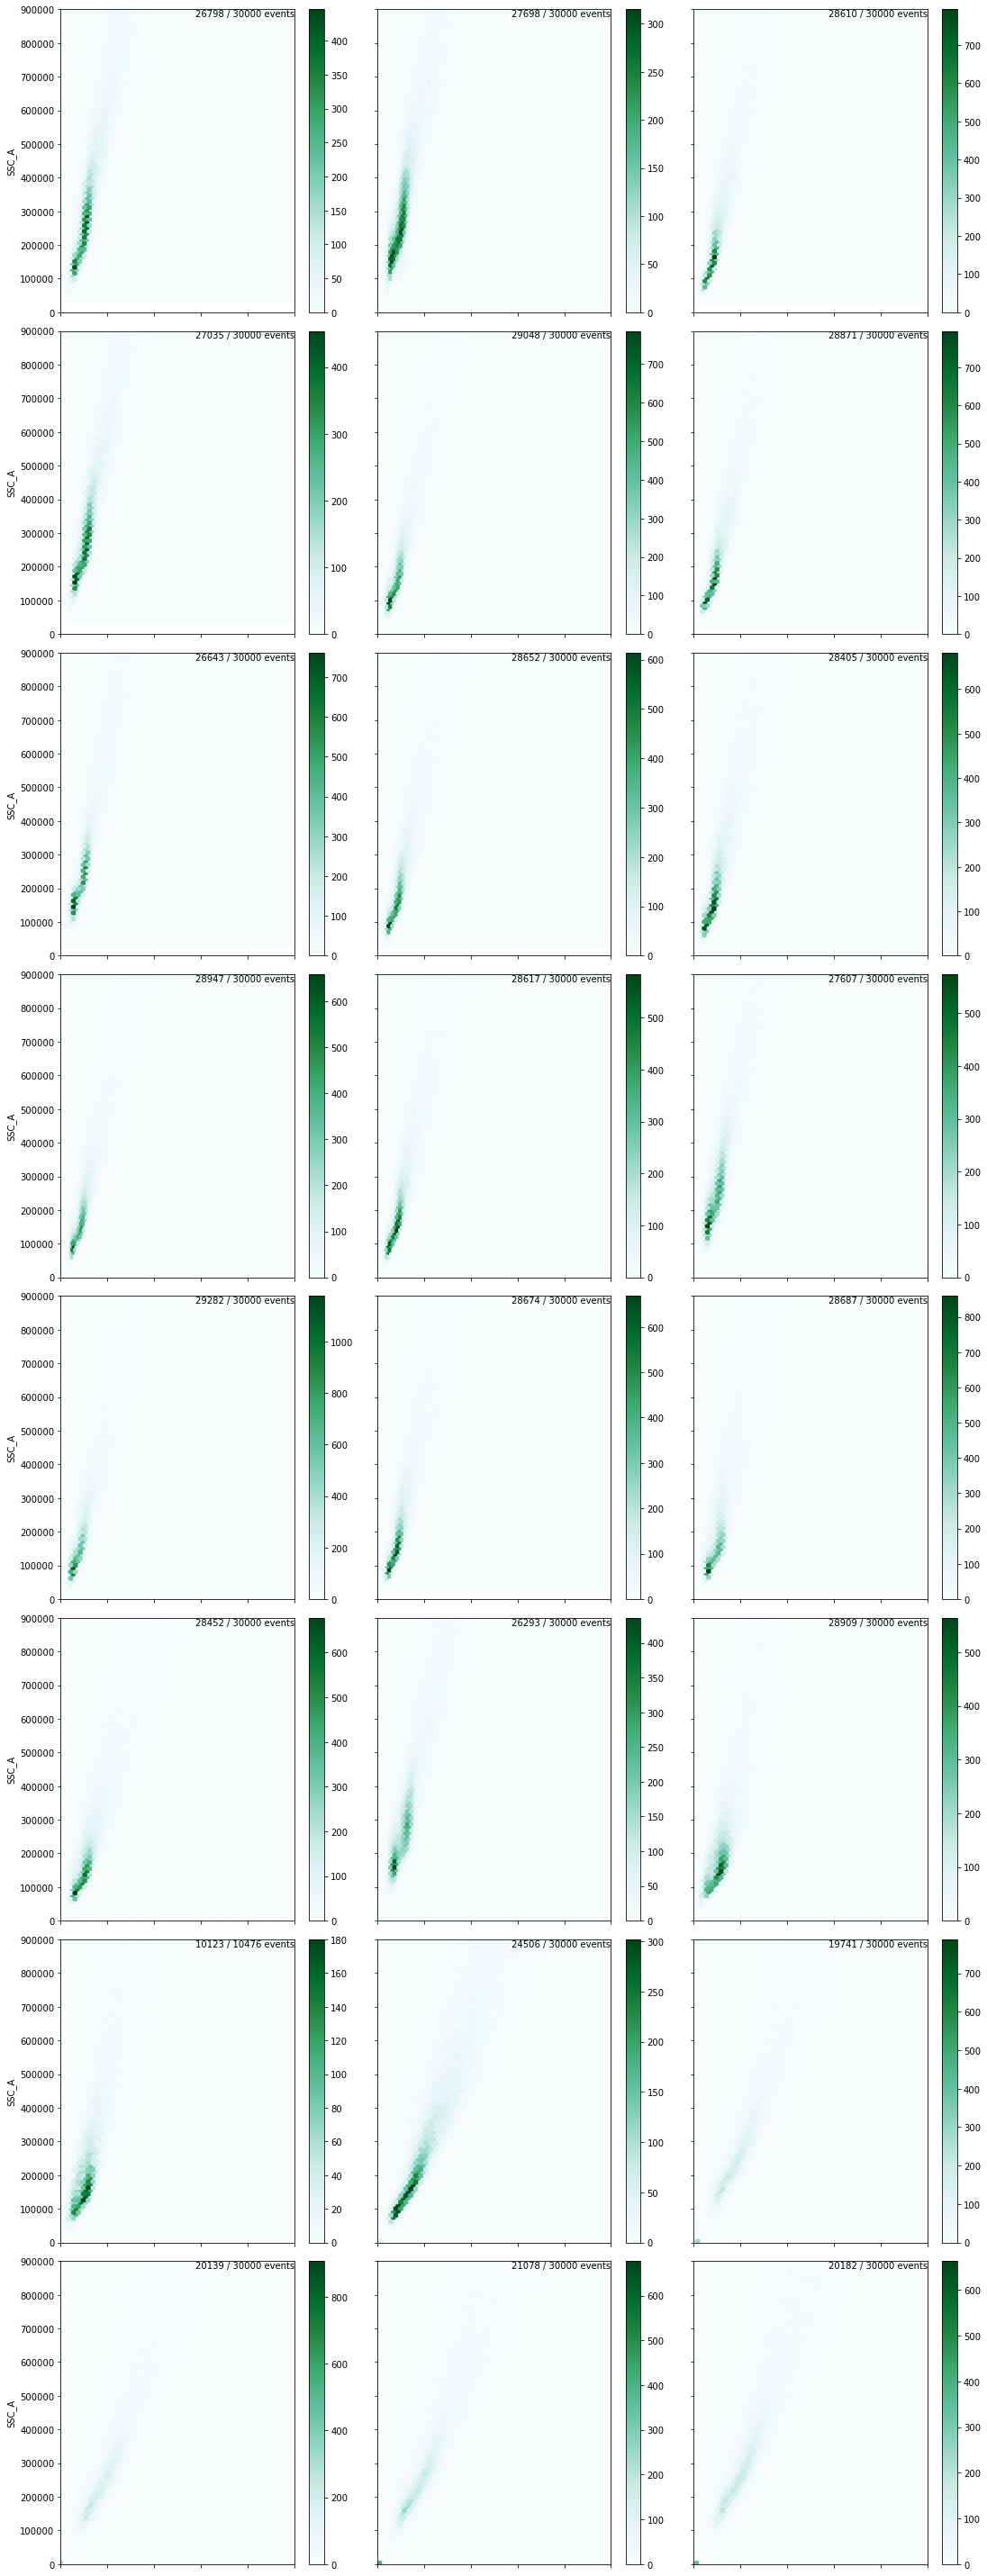

In [81]:
nrows = 8 ; ncols = 3
xlim = 500_000 ; ylim = 900_000
fig, axeses = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_size_inches(ncols * 5, nrows * 5)
fig.tight_layout()
i = 0
axeses = axeses.flatten()
axeses[0].set_xlim(0, xlim); axeses[0].set_ylim(0, ylim)
for group_name, group in filtered_df.groupby('lab_id'):
    if i >= (ncols * nrows):
        break
    ax = axeses[i]
    subset = group.query(f"FSC_A < {xlim} and SSC_A < {ylim}")
    ax.text(xlim, ylim, f'{subset.shape[0]} / {group.shape[0]} events', ha='right', va='top')
    group.plot.hexbin(x='FSC_A', y='SSC_A', ax=ax)

    i += 1

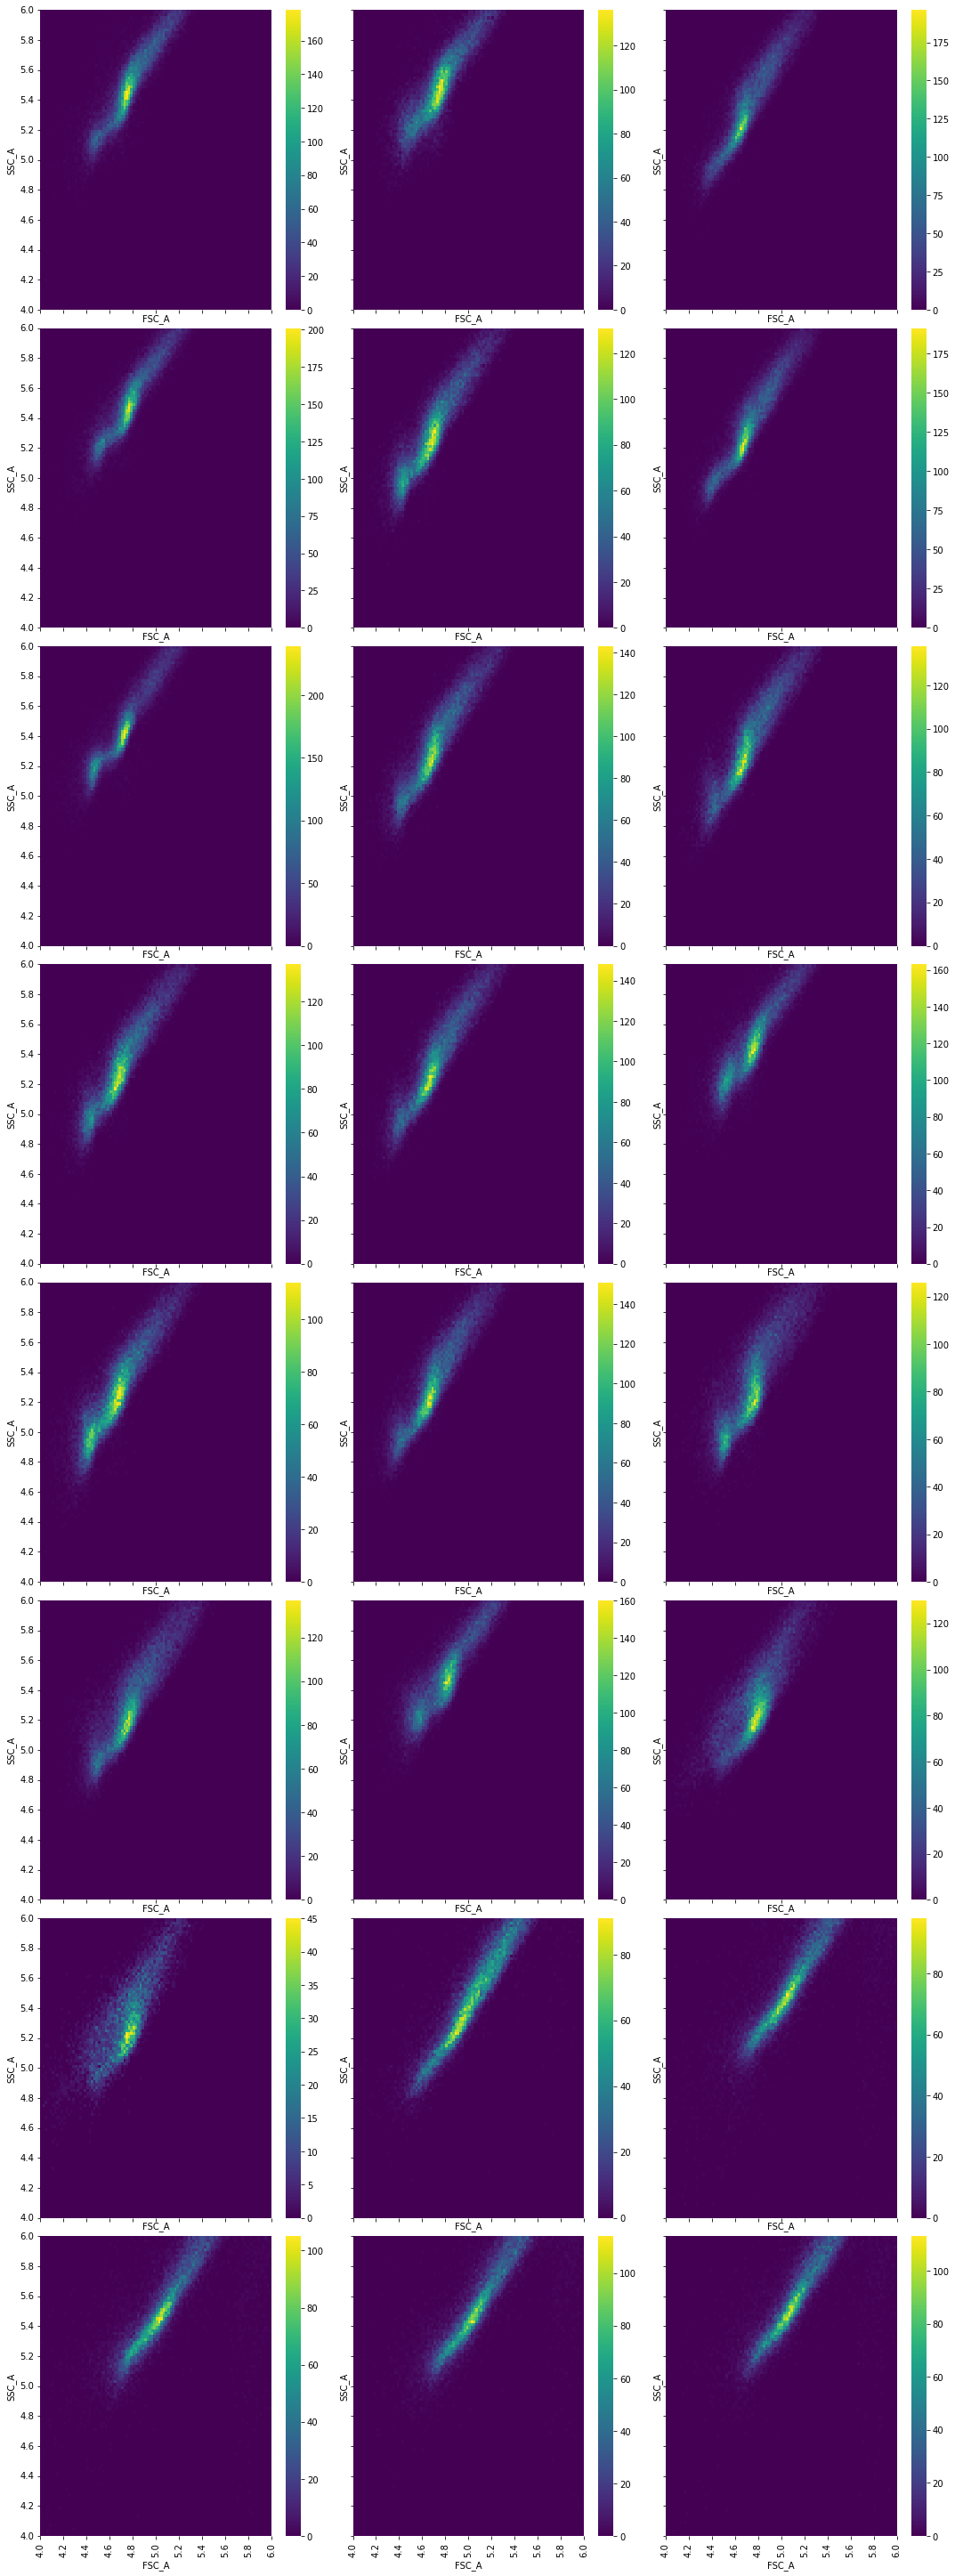

In [135]:
nrows = 8 ; ncols = 3
xlim = 20_000 ; ylim = 900_000
fig, axeses = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_size_inches(ncols * 5, nrows * 5)
fig.tight_layout()
i = 0
axeses = axeses.flatten()
for group_name, group in filtered_df.groupby('lab_id'):
    if i >= (ncols * nrows):
        break
    ax = axeses[i]
    subset = group.query(f"FSC_A < {xlim} and SSC_A < {ylim}")
    tmp = plot_helpers.point_cloud_to_histogram(group, logscale=True)
    plot_helpers.make_heatmap(tmp, logscale=True, ax=ax)
    i += 1

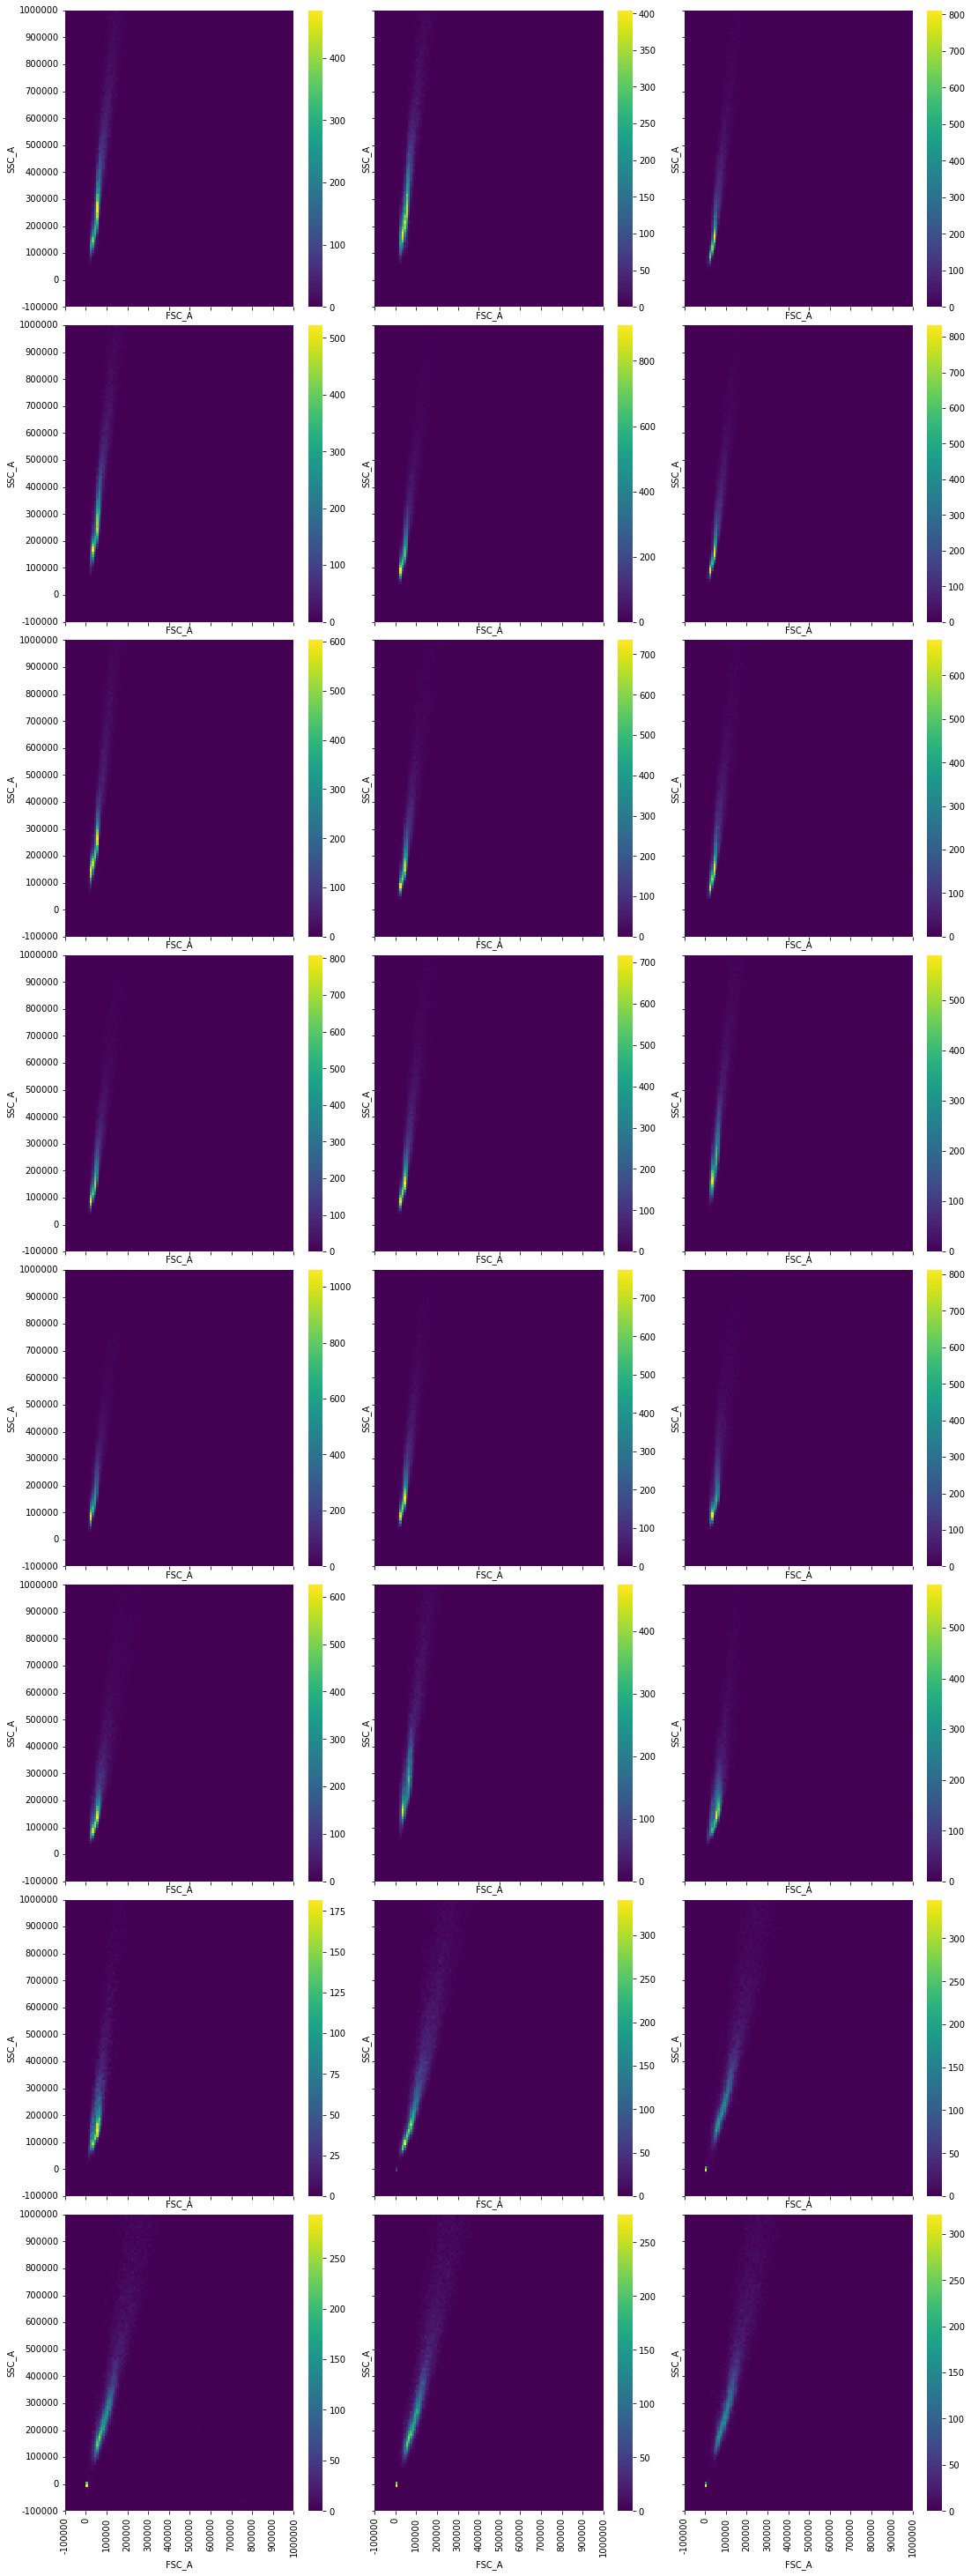

In [134]:
nrows = 8 ; ncols = 3
xlim = 500_000 ; ylim = 900_000
fig, axeses = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_size_inches(ncols * 5, nrows * 5)
fig.tight_layout()
i = 0
axeses = axeses.flatten()
for group_name, group in filtered_df.groupby('lab_id'):
    if i >= (ncols * nrows):
        break
    ax = axeses[i]
    subset = group.query(f"FSC_A < {xlim} and SSC_A < {ylim}")
    tmp = plot_helpers.point_cloud_to_histogram(group, logscale=False)
    plot_helpers.make_heatmap(tmp, logscale=False, ax=ax)
    i += 1

In [130]:
nrows = 8 ; ncols = 3
xlim = 500_000 ; ylim = 900_000
fig, axeses = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True)
fig.set_size_inches(ncols * 5, nrows * 5)
fig.tight_layout()
i = 0
axeses = axeses.flatten()
axeses[0].set_xlim(0, xlim); axeses[0].set_ylim(0, ylim)
for group_name, group in filtered_df.groupby('lab_id'):
    if i >= (ncols * nrows):
        break
    ax = axeses[i]
    subset = group.query(f"FSC_A < {xlim} and SSC_A < {ylim}")
    ax.text(xlim, ylim, f'{subset.shape[0]} / {group.shape[0]} events', ha='right', va='top')
    tmp = plot_helpers.point_cloud_to_histogram(group)
    plot_helpers.make_heatmap(tmp, logscale=False, ax=ax)
    i += 1

ValueError: Image size of 1181147x2755507 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x2880 with 48 Axes>

In [82]:
xlim = 500_000 ; ylim = 900_000
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(filtered_df.groupby('lab_id').apply(lambda df: pd.Series({'filtered_events': df.query(f"FSC_A < {xlim} and SSC_A < {ylim}").shape[0], 'events':df.shape[0]})))

                               filtered_events  events
lab_id                                                
r1c7cprv7fe49_r1c7jmje3ebhc              26798   30000
r1c7cpu9nj2bu_r1c7fg23qkzph              27698   30000
r1c7cpvfzqprk_r1c7fbvba55db              28610   30000
r1c84xvquwxth_r1c8ek7vcmdxh              27035   30000
r1c84xwx57y95_r1c8ejz8jfg9z              29048   30000
r1c84xzc5dbuv_r1c8axrywctwb              28871   30000
r1c84y3r9yqxb_r1c8auwvzbgt3              26643   30000
r1c8xx6qe9eea_r1c93enbf48t7              28652   30000
r1c8xx7we38vw_r1c93cukfcxqp              28405   30000
r1c8xx94j94u7_r1c93ajvdzxz5              28947   30000
r1c8yx25rrtag_r1c96v2w8x5pq              28617   30000
r1c8yydkumrkr_r1c96xsxw79c9              27607   30000
r1c8yyg9gxbme_r1c96wn43pq45              29282   30000
r1c9tpmcezpk2_r1c9wjnedp92f              28674   30000
r1cbajqru7kbe_r1cbe9p9zu6dh              28687   30000
r1cbut2pdjtwv_r1cc6qzwcd4hx              28452   30000
r1cbut3veu